In [1]:
!pip install japanize_matplotlib

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
from tensorflow.keras.utils import get_file

url = 'https://github.com/odashi/small_parallel_enja/archive/master.zip'

zip_file_path = get_file('small_parallel_enja.zip', url, cache_subdir='small_parallel_enja', extract=True) 

In [3]:
import os

data_dir = os.path.join(os.path.dirname(zip_file_path), 'small_parallel_enja-master')
!ls -l $data_dir

total 9076
-rw-r--r-- 1 tensorflow tensorflow    1946 Feb 10 06:20 README.md
-rw-r--r-- 1 tensorflow tensorflow   17054 Feb 10 06:20 dev.en
-rw-r--r-- 1 tensorflow tensorflow   27781 Feb 10 06:20 dev.ja
-rw-r--r-- 1 tensorflow tensorflow   17301 Feb 10 06:20 test.en
-rw-r--r-- 1 tensorflow tensorflow   27793 Feb 10 06:20 test.ja
-rw-r--r-- 1 tensorflow tensorflow 1701356 Feb 10 06:20 train.en
-rw-r--r-- 1 tensorflow tensorflow  339768 Feb 10 06:20 train.en.000
-rw-r--r-- 1 tensorflow tensorflow  340186 Feb 10 06:20 train.en.001
-rw-r--r-- 1 tensorflow tensorflow  341174 Feb 10 06:20 train.en.002
-rw-r--r-- 1 tensorflow tensorflow  339953 Feb 10 06:20 train.en.003
-rw-r--r-- 1 tensorflow tensorflow  340275 Feb 10 06:20 train.en.004
-rw-r--r-- 1 tensorflow tensorflow   30025 Feb 10 06:20 train.en.vocab.4k
-rw-r--r-- 1 tensorflow tensorflow   51162 Feb 10 06:20 train.en.vocab.all
-rw-r--r-- 1 tensorflow tensorflow 2784447 Feb 10 06:20 train.ja
-rw-r--r-- 1 tensorflow tensorflow  556444 Fe

In [4]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences

def load_data(path):
    tokenizer = Tokenizer(filters='')
    
    texts = []
    for line in open(path, 'r'):
        texts.append('<start> ' + line.strip() + ' <end>')
    
    tokenizer.fit_on_texts(texts)
    return tokenizer.texts_to_sequences(texts), tokenizer

en, inp_lang = load_data(os.path.join(data_dir, 'train.en'))
ja, targ_lang = load_data(os.path.join(data_dir, 'train.ja'))

vocab_inp_size = len(inp_lang.word_index) + 1
vocab_tar_size = len(targ_lang.word_index) + 1

train_en, test_en, train_ja, test_ja = train_test_split(en, ja, test_size=0.1, random_state=36)

input_tensor_train = pad_sequences(train_en, padding='post')
target_tensor_train = pad_sequences(train_ja, padding='post')
input_tensor_val = pad_sequences(test_en, padding='post')
target_tensor_val = pad_sequences(test_ja, padding='post')

max_length_inp = len(input_tensor_train[0])
max_length_targ = len(target_tensor_train[0])

In [5]:
def convert(lang, tensor):
    for t in tensor:
        if t!=0:
            print ("%d ----> %s" % (t, lang.index_word[t]))

In [6]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
5 ----> i
512 ----> walked
12 ----> in
4 ----> the
2801 ----> woods
51 ----> by
410 ----> myself
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
17 ----> 私
4 ----> は
265 ----> 一人
11 ----> で
1571 ----> 森
8 ----> を
198 ----> 歩
5 ----> い
7 ----> た
3 ----> 。
2 ----> <end>


In [7]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train) // BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [8]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 18]), TensorShape([64, 18]))

In [9]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [10]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# サンプル入力
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 18, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [11]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # スコアを計算するためにこのように加算を実行する
        hidden_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        # スコアを self.V に適用するために最後の軸は 1 となる
        # self.V に適用する前のテンソルの shape は  (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(
                      self.W1(values) + self.W2(hidden_with_time_axis)))

        # attention_weights の shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector の合計後の shape == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [12]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 18, 1)


In [13]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)

        # アテンションのため
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
        # enc_output の shape == (batch_size, max_length, hidden_size)
        context_vector, attention_weights = self.attention(hidden, enc_output)

        # 埋め込み層を通過したあとの x の shape  == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # 結合後の x の shape == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # 結合したベクトルを GRU 層に渡す
        output, state = self.gru(x)

        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))

        # output shape == (batch_size, vocab)
        x = self.fc(output)

        return x, state, attention_weights

In [14]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 8777)


In [15]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
                             from_logits=True, reduction='none')
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [16]:
import os

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [17]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)

        dec_hidden = enc_hidden

        dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

        # Teacher Forcing - 正解値を次の入力として供給
        for t in range(1, targ.shape[1]):
            # passing enc_output to the decoder
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

            loss += loss_function(targ[:, t], predictions)

            # Teacher Forcing を使用
            dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [18]:
import time

EPOCHS = 20

for epoch in range(EPOCHS):
    start = time.time()

    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss

        if batch % 100 == 0:
              print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                     batch,
                                                     batch_loss.numpy()))
    # 2 エポックごとにモデル（のチェックポイント）を保存
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 6.2661
Epoch 1 Batch 100 Loss 2.8958
Epoch 1 Batch 200 Loss 2.5642
Epoch 1 Batch 300 Loss 2.3151
Epoch 1 Batch 400 Loss 2.1025
Epoch 1 Batch 500 Loss 2.1533
Epoch 1 Batch 600 Loss 2.0071
Epoch 1 Batch 700 Loss 2.0877
Epoch 1 Loss 2.4364
Time taken for 1 epoch 119.46129512786865 sec

Epoch 2 Batch 0 Loss 1.9589
Epoch 2 Batch 100 Loss 1.9013
Epoch 2 Batch 200 Loss 1.8852
Epoch 2 Batch 300 Loss 1.7491
Epoch 2 Batch 400 Loss 1.6551
Epoch 2 Batch 500 Loss 1.7680
Epoch 2 Batch 600 Loss 1.5845
Epoch 2 Batch 700 Loss 1.5786
Epoch 2 Loss 1.7657
Time taken for 1 epoch 101.2643392086029 sec

Epoch 3 Batch 0 Loss 1.5686
Epoch 3 Batch 100 Loss 1.4646
Epoch 3 Batch 200 Loss 1.4449
Epoch 3 Batch 300 Loss 1.3569
Epoch 3 Batch 400 Loss 1.4870
Epoch 3 Batch 500 Loss 1.3600
Epoch 3 Batch 600 Loss 1.3369
Epoch 3 Batch 700 Loss 1.3782
Epoch 3 Loss 1.3719
Time taken for 1 epoch 101.10649156570435 sec

Epoch 4 Batch 0 Loss 1.1379
Epoch 4 Batch 100 Loss 1.1235
Epoch 4 Batch 200 Loss 1.040

In [19]:
def predict(inputs):
    inputs = tf.convert_to_tensor(inputs)
    predicted_seq = []
    
    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        # 後ほどプロットするためにアテンションの重みを保存
        attention_weights = tf.reshape(attention_weights, (-1, ))

        predicted_id = tf.argmax(predictions[0]).numpy()

        predicted_seq.append(predicted_id)

        if targ_lang.index_word[predicted_id] == '<end>':
            return predicted_seq

        # 予測された ID がモデルに戻される
        dec_input = tf.expand_dims([predicted_id], 0)

    return predicted_seq
    

In [20]:
import numpy as np

def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                           maxlen=max_length_inp,
                                                           padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        # 後ほどプロットするためにアテンションの重みを保存
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.index_word[predicted_id] + ' '

        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # 予測された ID がモデルに戻される
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [21]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import japanize_matplotlib

# アテンションの重みをプロットする関数
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [22]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [23]:
# checkpoint_dir の中の最後のチェックポイントを復元
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> i can 't hear you . <end>
Predicted translation: あなた の おっしゃ る こと が 聞こえ ま せ ん 。 <end> 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  


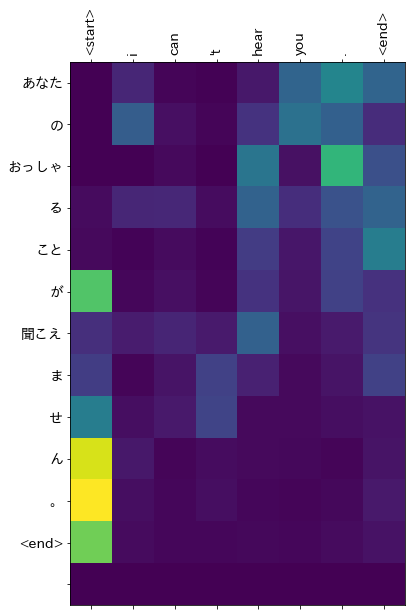

In [29]:
translate("<start> i can 't hear you . <end>")

In [25]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import pandas as pd

input_sentences = []
target_sentences = []
predicted_sentences = []

for i, input_en in enumerate(input_tensor_val):
    predicted_ja = predict([input_en])
    tokens_input = [inp_lang.index_word[id] for id in input_en if id > 2]
    tokens_target = [targ_lang.index_word[id] for id in target_tensor_val[i] if id > 2]
    tokens_predicted = [targ_lang.index_word[id] for id in predicted_ja if id > 2]
    input_sentences.append(' '.join(tokens_input))
    target_sentences.append(''.join(tokens_target))
    predicted_sentences.append(''.join(tokens_predicted))

result_df = pd.DataFrame({'input_sentence': input_sentences,
                          'target_sentence': target_sentences,
                          'predicted_sentence': predicted_sentences})  


In [26]:
bleu_scores = []
for row in result_df.itertuples():
    bleu_scores.append(
        sentence_bleu(row.target_sentence, row.predicted_sentence,
                      smoothing_function=SmoothingFunction().method4)
    )
result_df['bleu_score'] = bleu_scores

In [27]:
result_df

,input_sentence,target_sentence,predicted_sentence,bleu_score
0,i was wrong .,私が間違っていました。,私は間違っていました。,0.533355
1,she is going to learn how to drive .,彼女は近く、運転を習うつもりでいます。,彼女は車を学ぶ気が立っています。,0.311208
2,i am fond of skiing .,私はスキーが好きだ。,スキーが好き。,0.932776
3,i will start working on july the first .,７月１日から仕事を始めます。,私は一番のところを始めます。,0.342626
4,ken took the examination with confidence .,ケンは自信をもって試験を受けた。,ケンは試験を受けた。,0.606993
...,...,...,...,...
4995,either you or i am in the wrong .,あなたか私かどちらかが間違っている。,君か僕の意見が間違っている。,0.379178
4996,you 've got it in one . that 's right .,君はすぐに分かったんだね。そのとおりだよ。,それはそれであると思ったのだから。,0.297320
4997,all you have to do is believe me .,君は僕を信じさえすれば良い。,君は私を信じさえすればよい。,0.407453
4998,i was embarrassed by what she said .,彼女の言葉を聞いてどぎまぎした。,僕は彼女の言って彼女の言ってしまったことに困惑,0.200410


In [28]:
result_df.bleu_score.mean()

0.4239057127925631